In [1]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

In [27]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [94]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, concatenate, AveragePooling2D
from keras.utils import np_utils
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pydot
import matplotlib.gridspec as gridspec
from random import randint
%matplotlib inline

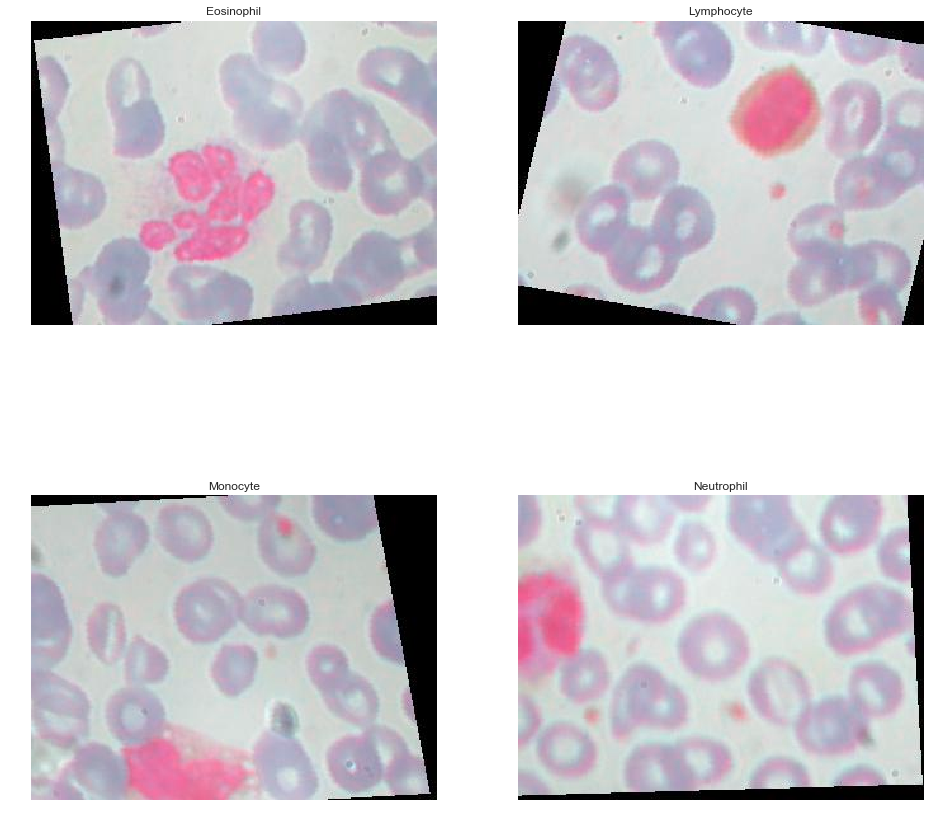

In [101]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = './input/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = './input/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = './input/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = './input/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

In [102]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))   #改变图像大小并且隐藏归一化到0-255区间的操作
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

In [103]:
print(np.shape(X_train))
print(np.shape(X_train[9000][:,:,0]))
print(X_train[9000])

(9957, 60, 80, 3)
(60, 80)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00279892 0.00270665 0.00296809]
  [0.00296809 0.00307574 0.00318339]
  [0.00306036 0.00329104 0.00329104]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00295271 0.00304498 0.00315263]
  [0.00313725 0.00327566 0.00327566]
  [0.00315263 0.0033218  0.00324491]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.0031065  0.00329104 0.00329104]
  [0.00318339 0.00329104 0.00324491]
  [0.00321415 0.00329104 0.00321415]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.     

In [104]:
X_train, y_train, z_train = get_data('./input/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('./input/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

  0%|          | 0/2499 [00:00<?, ?it/s]/Users/liyanran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 620/620 [00:03<00:00, 164.18it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


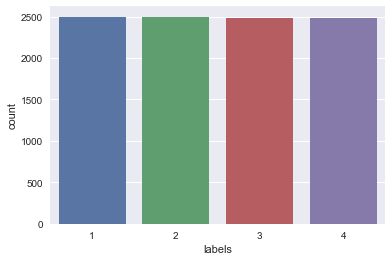

In [105]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [112]:
X_train[9000]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.71372549, 0.69019608, 0.75686275],
        [0.75686275, 0.78431373, 0.81176471],
        [0.78039216, 0.83921569, 0.83921569]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.75294118, 0.77647059, 0.80392157],
        [0.8       , 0.83529412, 0.83529412],
        [0.80392157, 0.84705882, 0.82745098]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.79215686, 0.83921569, 0.83921569],
        [0.81176471, 0.83921569, 0.82745098],
        [0.81960784, 0.83921569, 0.81960784]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [117]:
model(X_train[9000])

ValueError: Layer model_2 was called with an input that isn't a symbolic tensor. Received type: <class 'numpy.ndarray'>. Full input: [array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.71372549, 0.69019608, 0.75686275],
        [0.75686275, 0.78431373, 0.81176471],
        [0.78039216, 0.83921569, 0.83921569]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.75294118, 0.77647059, 0.80392157],
        [0.8       , 0.83529412, 0.83529412],
        [0.80392157, 0.84705882, 0.82745098]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.79215686, 0.83921569, 0.83921569],
        [0.81176471, 0.83921569, 0.82745098],
        [0.81960784, 0.83921569, 0.81960784]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])]. All inputs to the layer should be tensors.

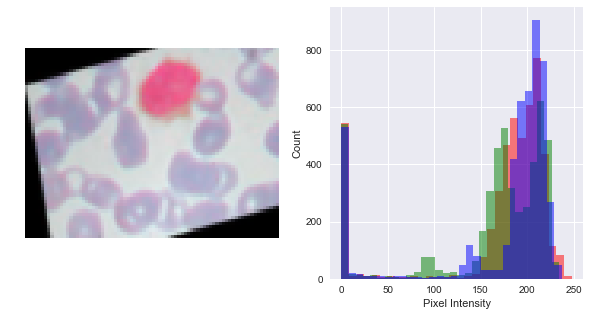

In [106]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[9000])

In [111]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

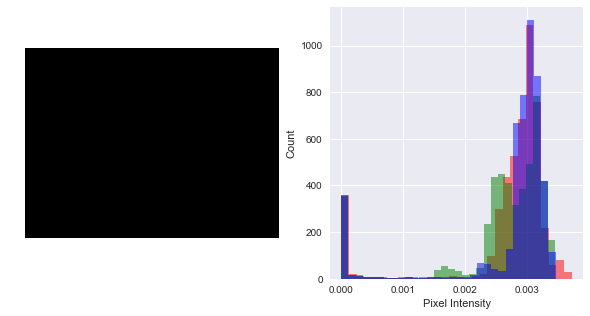

In [100]:
plotHistogram(X_train[1])

In [87]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_accuracy_curve(history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    
def plot_loss_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Epoch 1/30
312/311 [==============================] - 166s 532ms/step - loss: 1.4117 - acc: 0.2515 - val_loss: 1.3894 - val_acc: 0.2505
Epoch 2/30
312/311 [==============================] - 158s 508ms/step - loss: 1.3927 - acc: 0.2454 - val_loss: 1.3877 - val_acc: 0.2505
Epoch 3/30
312/311 [==============================] - 159s 511ms/step - loss: 1.3896 - acc: 0.2475 - val_loss: 1.3869 - val_acc: 0.2493
Epoch 4/30
312/311 [==============================] - 160s 514ms/step - loss: 1.3885 - acc: 0.2530 - val_loss: 1.3881 - val_acc: 0.2505
Epoch 5/30
312/311 [==============================] - 178s 569ms/step - loss: 1.3885 - acc: 0.2491 - val_loss: 1.3869 - val_acc: 0.2493
Epoch 6/30
312/311 [==============================] - 179s 574ms/step - loss: 1.3880 - acc: 0.2512 - val_loss: 1.3868 - val_acc: 0.2505
Epoch 7/30
312/311 [==============================] - 186s 597ms/step - loss: 1.3879 - acc: 0.2469 - val_loss: 1.3874 - val_acc: 0.2493
Epoch 8/30
312/311 [============================

/Users/liyanran/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


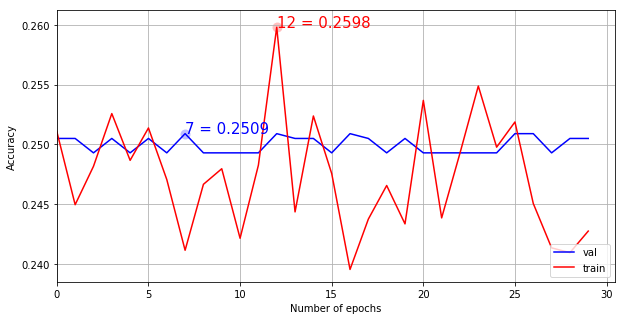

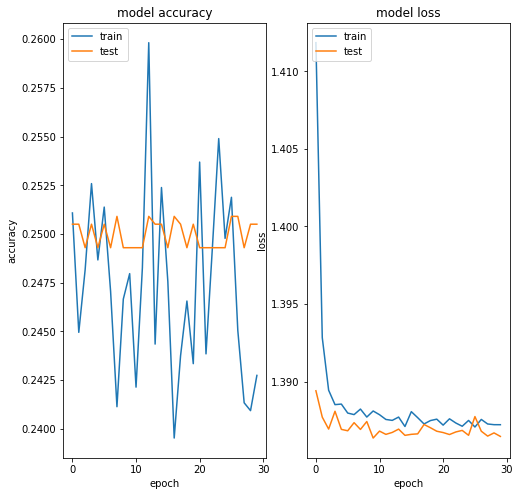

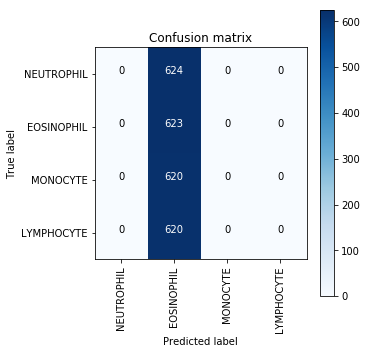

In [28]:
import keras
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    return(history)
#     plotKerasLearningCurve()
#     plt.show()  
#     plot_learning_curve(history)
#     plt.show()
#     confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
#     plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
#     plt.show()
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

In [64]:
def keras_model(block_num=2):
    inp = Input(shape=(60,80,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(2,2))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k)
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        #if j%2 == 0:
        #    x = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(x)
        #x = BatchNormalization(axis=-1)(x)
        k = x
   # x = Dropout(0.5)(k)
    x = MaxPool2D(pool_size=(7, 7), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    #x = Dense(1024,activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    y = Dense(5,activation="softmax")(x)
#    z = Dense(2,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model
model = keras_model(4)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 60, 80, 3)    12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 30, 40, 32)   4736        batch_normalization_4[0][0]      
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 15, 20, 32)   0           conv2d_90[0][0]                  
__________________________________________________________________________________________________
conv2d_91 

In [75]:
filepath = "./weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_trainHot,
         epochs = 60,
         batch_size = 32,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)

Train on 9957 samples, validate on 2487 samples
Epoch 1/60
9957/9957 [==============================] - 33s 3ms/step - loss: 0.2710 - acc: 0.8845 - val_loss: 0.5400 - val_acc: 0.8303

Epoch 00001: val_acc improved from -inf to 0.83032, saving model to ./weight_tr5.hdf5
Epoch 2/60
9957/9957 [==============================] - 32s 3ms/step - loss: 0.2174 - acc: 0.9100 - val_loss: 0.4402 - val_acc: 0.8400

Epoch 00002: val_acc improved from 0.83032 to 0.83997, saving model to ./weight_tr5.hdf5
Epoch 3/60
9957/9957 [==============================] - 31s 3ms/step - loss: 0.1931 - acc: 0.9208 - val_loss: 0.4454 - val_acc: 0.8376

Epoch 00003: val_acc did not improve from 0.83997
Epoch 4/60
9957/9957 [==============================] - 31s 3ms/step - loss: 0.1606 - acc: 0.9390 - val_loss: 0.6497 - val_acc: 0.8408

Epoch 00004: val_acc improved from 0.83997 to 0.84077, saving model to ./weight_tr5.hdf5
Epoch 5/60
9957/9957 [==============================] - 31s 3ms/step - loss: 0.1631 - acc: 0.9

9957/9957 [==============================] - 31s 3ms/step - loss: 0.0437 - acc: 0.9887 - val_loss: 0.7447 - val_acc: 0.8577

Epoch 00043: val_acc did not improve from 0.86852
Epoch 44/60
9957/9957 [==============================] - 31s 3ms/step - loss: 0.0136 - acc: 0.9956 - val_loss: 0.8391 - val_acc: 0.8520

Epoch 00044: val_acc did not improve from 0.86852
Epoch 45/60
9957/9957 [==============================] - 31s 3ms/step - loss: 0.0356 - acc: 0.9905 - val_loss: 0.9248 - val_acc: 0.8597

Epoch 00045: val_acc did not improve from 0.86852
Epoch 46/60
9957/9957 [==============================] - 31s 3ms/step - loss: 0.0094 - acc: 0.9972 - val_loss: 0.9782 - val_acc: 0.8649

Epoch 00046: val_acc did not improve from 0.86852
Epoch 47/60
9957/9957 [==============================] - 32s 3ms/step - loss: 0.0218 - acc: 0.9943 - val_loss: 0.5911 - val_acc: 0.8251

Epoch 00047: val_acc did not improve from 0.86852
Epoch 48/60
9957/9957 [==============================] - 31s 3ms/step - loss:

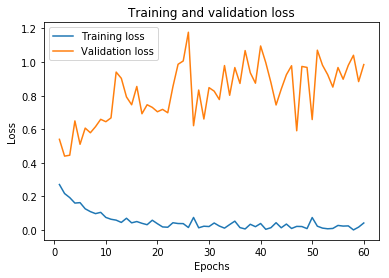

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

AttributeError: module 'seaborn' has no attribute 'lineplot'

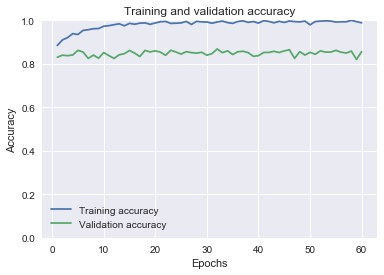

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.ylim(0, 1)
plt.legend()

ax = sns.lineplot(x=epochs, y=acc)

sns.plt.show()

Epoch 1/30
312/311 [==============================] - 45s 146ms/step - loss: 0.7058 - acc: 0.4962 - val_loss: 0.6931 - val_acc: 0.5030
Epoch 2/30
312/311 [==============================] - 42s 134ms/step - loss: 0.6943 - acc: 0.4925 - val_loss: 0.6930 - val_acc: 0.5099
Epoch 3/30
312/311 [==============================] - 42s 134ms/step - loss: 0.6935 - acc: 0.5054 - val_loss: 0.6933 - val_acc: 0.4986
Epoch 4/30
312/311 [==============================] - 42s 136ms/step - loss: 0.6939 - acc: 0.5003 - val_loss: 0.6923 - val_acc: 0.5601
Epoch 5/30
312/311 [==============================] - 43s 138ms/step - loss: 0.6885 - acc: 0.5489 - val_loss: 0.6821 - val_acc: 0.5786
Epoch 6/30
312/311 [==============================] - 43s 137ms/step - loss: 0.6457 - acc: 0.6294 - val_loss: 0.5359 - val_acc: 0.7447
Epoch 7/30
312/311 [==============================] - 43s 139ms/step - loss: 0.5531 - acc: 0.7133 - val_loss: 0.5570 - val_acc: 0.7165
Epoch 8/30
312/311 [==============================] - 4

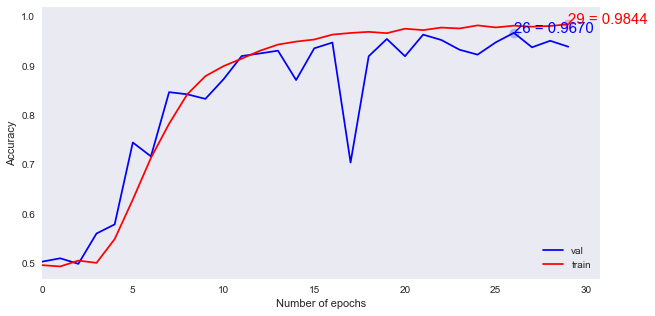

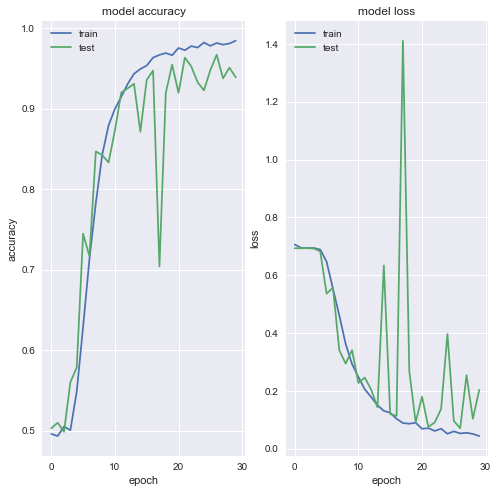

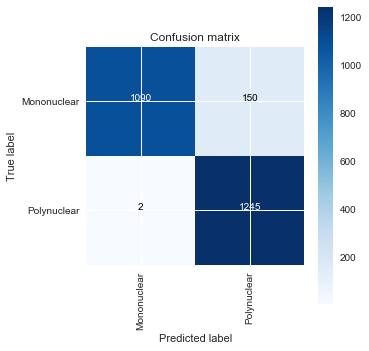

In [83]:
dict_characters = dict_characters2
runKerasCNNAugment(X_train,z_trainHot,X_test,z_testHot,2)   
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

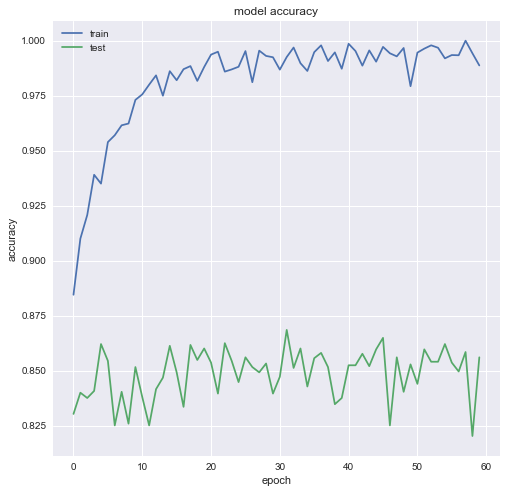

In [90]:
plot_accuracy_curve(history)

In [95]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(8, 8, wspace=0.2, hspace=0.2)

for i in range(53):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_prob = model.predict(pred_image).reshape(4)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3], pred_prob)
            fig.add_subplot(ax)

fig.show()

NameError: name 'pred_images' is not defined

<Figure size 2160x2160 with 0 Axes>